In [1]:
import numpy as np
from sklearn import metrics
from work_v2 import get_model, get_test_datagen, count_files
import matplotlib.pyplot as plt
import itertools
from PIL import Image

Using TensorFlow backend.


In [2]:
position = 'PA'
group = 'M_Adult'
test_path = 'data/{position}/train_256_3ch_flip/{group}/test/'.format(position=position, group=group)

In [3]:
batch_size = 32
target_size = (224, 224)
n_steps_test = np.ceil(count_files(test_path) / batch_size)

In [4]:
def scores_from_model_top(model, top):
    weights_path = 'saved_models/{model}/{top}/top_trained.h5'.format(model=model, top=top)
    full_model = get_model(model, top)
    full_model.load_weights(weights_path)
    test_datagen = get_test_datagen(model)
    test_generator = test_datagen.flow_from_directory(
            test_path,
            # target_size=(224, 224),
            reader_config={'target_mode': 'RGB', 'target_size': target_size},
            batch_size=batch_size,
            shuffle=False)
    preds = full_model.predict_generator(
        generator=test_generator,
        steps=n_steps_test,
        workers=4,
        verbose=1)
    scores = preds[:,1]
    return scores        

In [5]:
def roc_curve_figs(model, top):
    scores = scores_from_model_top(model, top)
    y = 436*[0]+436*[1]
    fpr, tpr, thresholds = metrics.roc_curve(y, scores, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    
    fig = plt.figure(figsize=[3,3])
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC {}, {}'.format(model, top))
    plt.legend(loc="lower right")
    
    return fig

In [9]:
models = ['resnet50', 'vgg16', 'vgg19']
tops = ['chollet', 'waya', 'linear']
# figs = [roc_curve_figs(model, top) for model, top in itertools.product(models, tops)]
scores = [scores_from_model_top(model, top) for model, top in itertools.product(models, tops)]

Found 872 images belonging to 2 classes.
28/28 [==============================] - 11s    
Found 872 images belonging to 2 classes.
28/28 [==============================] - 10s    
Found 872 images belonging to 2 classes.
28/28 [==============================] - 10s    
Found 872 images belonging to 2 classes.
28/28 [==============================] - 19s    
Found 872 images belonging to 2 classes.
28/28 [==============================] - 15s    
Found 872 images belonging to 2 classes.
28/28 [==============================] - 15s    
Found 872 images belonging to 2 classes.
28/28 [==============================] - 18s    
Found 872 images belonging to 2 classes.
28/28 [==============================] - 18s    
Found 872 images belonging to 2 classes.
28/28 [==============================] - 18s    


In [10]:
def ensemble_roc_auc(y, scores, combination):
    ensemble_score = np.mean([scores[combination[0]], scores[combination[1]]], axis=0)
    fpr, tpr, thresholds = metrics.roc_curve(y, ensemble_score, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

In [11]:
def ensemble_precision_recall(y, scores, combination):
    ensemble_score = np.mean([scores[combination[0]], scores[combination[1]]], axis=0)
    precision, recall, thresholds = metrics.precision_recall_curve(y, ensemble_score)
    return precision, recall, thresholds

In [13]:
y = 436*[0]+436*[1]
combinations = [comb for comb in itertools.combinations(range(9), 2)]
aucs = [ensemble_roc_auc(y, scores, comb) for comb in combinations]
comb_names = [(m1, m2) for (m1, m2) in itertools.combinations(itertools.product(models, tops), 2)]
print('Max AUC: {}. \nTop combination: {}'.format(np.max(aucs),  comb_names[np.argmax(aucs)]))

Max AUC: 0.704407246864742. 
Top combination: (('vgg16', 'waya'), ('vgg19', 'linear'))


In [14]:
best_comb = combinations[np.argmax(aucs)]
best_ensemble = np.mean([scores[best_comb[0]], scores[best_comb[1]]], axis=0)
prec_rec = ensemble_precision_recall(y, scores, best_comb)
avg_prec = metrics.average_precision_score(y, best_ensemble)

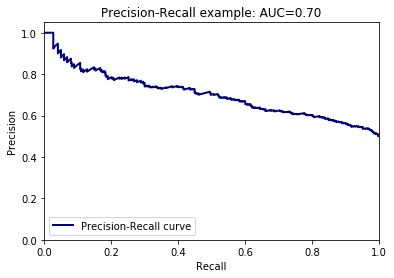

In [17]:
# Plot Precision-Recall curve
lw=2
plt.clf()
plt.plot(prec_rec[1], prec_rec[0], lw=lw, color='navy',
         label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(avg_prec))
plt.legend(loc="lower left")
plt.show()